In [ ]:
! unzip dataset_task1.zip

Streaming output truncated to the last 5000 lines.
  inflating: bonus/bonus_green_1707_JeTS.png  
  inflating: bonus/bonus_red_1443_FARmErs.png  
  inflating: bonus/bonus_green_1362_PhilIp.png  
  inflating: bonus/bonus_red_549_RETRieVeD.png  
  inflating: bonus/bonus_green_1528_RedUCES.png  
  inflating: bonus/bonus_red_2202_iNtEL.png  
  inflating: bonus/bonus_green_18_aSsOcIATIONS.png  
  inflating: bonus/bonus_green_1723_geNealoGy.png  
  inflating: bonus/bonus_red_1217_wingS.png  
  inflating: bonus/bonus_red_1350_lAtER.png  
  inflating: bonus/bonus_red_1295_MaYBe.png  
  inflating: bonus/bonus_red_1587_FarmERs.png  
  inflating: bonus/bonus_green_2460_orgaNizeD.png  
  inflating: bonus/bonus_green_1824_PrOtECtEd.png  
  inflating: bonus/bonus_red_714_ROOm.png  
  inflating: bonus/bonus_green_430_shADeS.png  
  inflating: bonus/bonus_red_212_caLEnDar.png  
  inflating: bonus/bonus_green_1294_SainT.png  
  inflating: bonus/bonus_green_1582_iNTel.png  
  inflating: bonus/bonus_gree

In [ ]:
import torch.nn as nn
import torch



class Convmodule(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=(1,1), padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=1)
        self.relu4 = nn.ReLU(inplace=True)


        self.pool4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,1), padding=(0,1))

        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1,1), padding=1)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU(inplace=True)

        self.conv6 = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=1)
        self.batchnorm2 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU(inplace=True)

        self.pool6 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,1), padding=(0,1))

        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2,2), stride=(1,1), padding=0)

    def forward(self, input):
        x = self.pool1(self.relu1(self.conv1(input)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = self.relu3(self.conv3(x))
        x = self.pool4(self.relu4(self.conv4(x)))

        x = self.batchnorm1(self.conv5(x))
        x = self.relu5(x)

        x = self.batchnorm2(self.conv6(x))
        x = self.relu6(x)
        x = self.pool6(x)

        x = self.conv7(x)
        return x

class  WordsOCR(nn.Module):
    def __init__(self, num_classes = 100):
        super(WordsOCR, self).__init__()

        self.cnn = Convmodule()

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))


        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        features = self.cnn(x)

        pooled = self.global_pool(features)

        flattened = pooled.view(pooled.size(0), -1)

        output = self.fc(flattened)

        return output

In [ ]:
import os


with open("words_task1.txt") as f:
  all_words = [i.strip().lower() for i in f.readlines()]

assert len(all_words) == len(set(all_words))
print(len(all_words))


100


In [ ]:
import numpy as np

class Encoding():
  def __init__(self,words = all_words):
    self.words = words

    self.word_to_idx = {w: i for i, w in enumerate(words)}

  def encode(self,word):
      return self.word_to_idx[word]

  def decode(self, data):
          """
          Decodes either a Model Distribution OR a Label Index back to text.
          """
          # if Input is a Tensor (Model Output or Batch of Labels)
          if isinstance(data, torch.Tensor):
              data = data.detach().cpu().numpy()

          # situtionB: Input is a Probability Distribution (List/Array)
          # e.g., [0.1, 0.8, 0.1] -> We take argmax to find index
          if isinstance(data, (list, np.ndarray)):
              # If it's a single scalar wrapped in an array (e.g. array(2))
              if np.array(data).ndim == 0:
                  idx = int(data)
              # If it is a distribution/vector
              elif len(data) == len(self.words):
                  idx = np.argmax(data)
              else:
                  raise ValueError("Shape mismatch in decode")
          # Case C: Input is already an integer index
          else:
              idx = int(data)

          return self.words[idx]


encoder = Encoding()



In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

class CaptchDataset(Dataset):

  def __init__(self,folder,labels,transform =  None):
    self.imgdir = folder
    self.labels = labels

    self.transform = transform
    self.df = pd.read_csv(self.labels,header=None,names=["filename","label","imagetype"],dtype=str)

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    img_path = os.path.join(self.imgdir, row["filename"])
    label_text = str(row["label"])

    label_tensor = encoder.encode(label_text)
    #to make sure for an effective split returs green or red for bonus dataset
    imagetype = str(row["imagetype"])
    image = Image.open(img_path).convert("RGB")
    if self.transform:
          image = self.transform(image)

    label = torch.tensor(label_tensor, dtype=torch.long)
    return image, label, imagetype



In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((32, 128)), # Fixed size for batching
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
EASY = CaptchDataset("/content/easy",labels="/content/easy/labels.csv",transform=transform)
HARD = CaptchDataset("/content/hard",labels="/content/hard/labels.csv",transform = transform)
BONUS = CaptchDataset("/content/bonus",labels="/content/bonus/labels.csv",transform = transform)

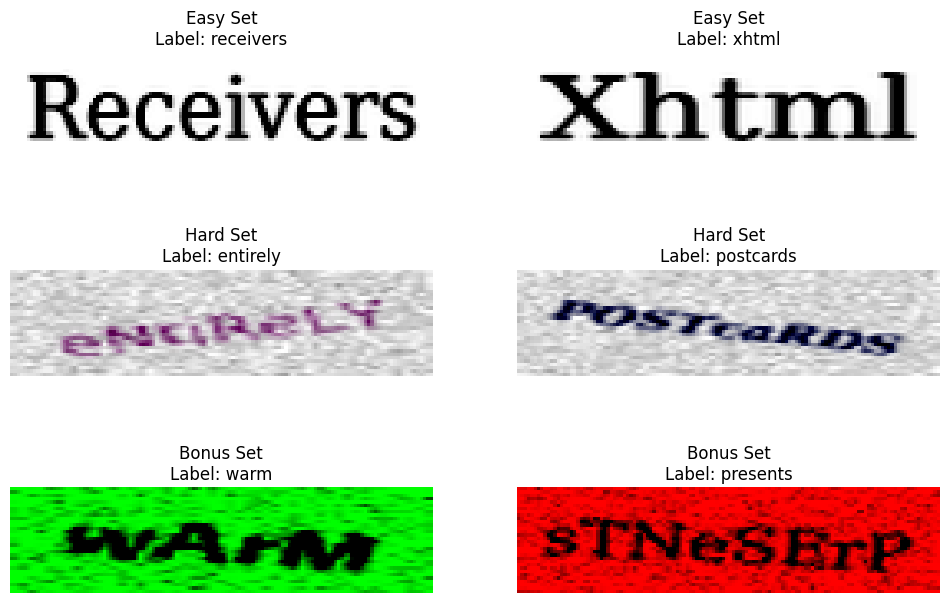

In [ ]:
import matplotlib.pyplot as plt

datasets = [("Easy Set", EASY), ("Hard Set", HARD), ("Bonus Set", BONUS)]
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for row_idx, (name, dataset) in enumerate(datasets):
    indices = torch.randint(0, len(dataset), (2,))

    for col_idx, idx in enumerate(indices):
        img_tensor, label, _  = dataset[idx.item()]

        if torch.is_tensor(label):
            label = encoder.decode(label)

        # Plotting
        ax = axes[row_idx, col_idx]
        ax.imshow(img_tensor.permute(1, 2, 0))
        ax.set_title(f"{name}\nLabel: {label}")
        ax.axis('off')


In [ ]:
from torch.utils.data import ConcatDataset, Subset
from torch.utils.data import random_split

train_ratio = 0.85

red_indices = [i for i, row in BONUS.df.iterrows() if "red" == row["imagetype"]]
green_indices = [i for i, row in BONUS.df.iterrows() if "green" == row["imagetype"]]

BONUS_RED = Subset(BONUS, red_indices)
BONUS_GREEN = Subset(BONUS, green_indices)



# split each dataset with 0.85 and 0.15 and concatente everything
def split_it(dataset):
  DATASET_SIZE = len(dataset)
  train_size = int(DATASET_SIZE * 0.85)
  validation = DATASET_SIZE - train_size
  train_size = int(DATASET_SIZE * tra/content/in_ratio)
  validation = DATASET_SIZE - train_size
  train_dataset, valid_dataset = random_split(dataset, [train_size, validation])

  return train_dataset , valid_dataset


Train_Bonusred , Valid_Bonusred = split_it(BONUS_RED)
Train_Bonusgreen , Valid_Bonusgreen = split_it(BONUS_GREEN)

Train_easy , Valid_easy = split_it(EASY)

Train_hard , Valid_hard = split_it(HARD)

Totaldataset = ConcatDataset([EASY, HARD, BONUS])

train_dataset = ConcatDataset([Train_easy,Train_hard,Train_Bonusgreen,Train_Bonusred])
valid_dataset = ConcatDataset([Valid_easy,Valid_hard,Valid_Bonusred,Valid_Bonusgreen])


print(f"percentage split train= {len(train_dataset) / len(Totaldataset) * 100:.2f}" )
print(f"percentage split valid= {len(valid_dataset) / len(Totaldataset) * 100:.2f}" )



print(f"Total Samples: {len(Totaldataset)}")
print(f"Train Samples: {len(train_dataset)}")
print(f"Test  Samples: {len(valid_dataset)}")

percentage split train= 84.99
percentage split valid= 15.01
Total Samples: 15000
Train Samples: 12749
Test  Samples: 2251


In [ ]:
count_dict_train = {"easy":0,"hard":0,"green":0,"red":0}
count_dict_valid = {"easy":0,"hard":0,"green":0,"red":0}

for i in train_dataset:
   _,_,category =  i
   count_dict_train[category] +=1

for i in valid_dataset:
  _,_,category =  i
  count_dict_valid[category] +=1


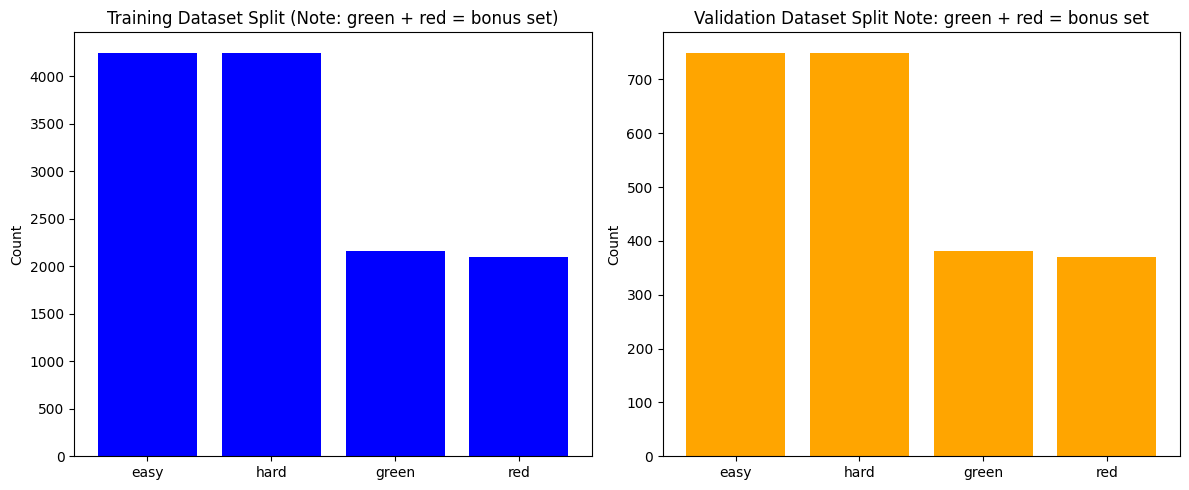

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left Plot: Training Dataset
ax1.bar(count_dict_train.keys(), count_dict_train.values(), color='blue')
ax1.set_title("Training Dataset Split (Note: green + red = bonus set)")
ax1.set_ylabel("Count")

# Right Plot: Validation Dataset
ax2.bar(count_dict_valid.keys(), count_dict_valid.values(), color='orange')
ax2.set_title("Validation Dataset Split Note: green + red = bonus set")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.savefig("Split.png")
plt.show()

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        # Check if loss improved significantly
        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            print(f"    [EarlyStopping] {self.counter}/{self.patience} epochs without improvement.")
            if self.counter >= self.patience:
                self.early_stop = True

Starting Task 1 Classification Training on cuda...

Epoch 1/100
  Train Loss: 4.7564 | Train Acc: 0.97%
  Val Loss:   4.6270 | Val Acc:   1.01%

Epoch 2/100
  Train Loss: 4.4967 | Train Acc: 1.48%
  Val Loss:   4.0807 | Val Acc:   3.08%

Epoch 3/100
  Train Loss: 3.5509 | Train Acc: 9.46%
  Val Loss:   2.9228 | Val Acc:   17.56%

Epoch 4/100
  Train Loss: 2.5288 | Train Acc: 30.18%
  Val Loss:   2.0324 | Val Acc:   43.30%

Epoch 5/100
  Train Loss: 1.8219 | Train Acc: 47.73%
  Val Loss:   1.5766 | Val Acc:   54.47%

Epoch 6/100
  Train Loss: 1.3350 | Train Acc: 60.15%
  Val Loss:   1.0125 | Val Acc:   68.85%

Epoch 7/100
  Train Loss: 0.9357 | Train Acc: 70.73%
  Val Loss:   0.8514 | Val Acc:   74.23%

Epoch 8/100
  Train Loss: 0.6100 | Train Acc: 80.61%
  Val Loss:   0.5345 | Val Acc:   83.32%

Epoch 9/100
  Train Loss: 0.3954 | Train Acc: 87.36%
  Val Loss:   0.4181 | Val Acc:   86.62%

Epoch 10/100
  Train Loss: 0.2762 | Train Acc: 91.08%
  Val Loss:   0.4192 | Val Acc:   85.65%
   

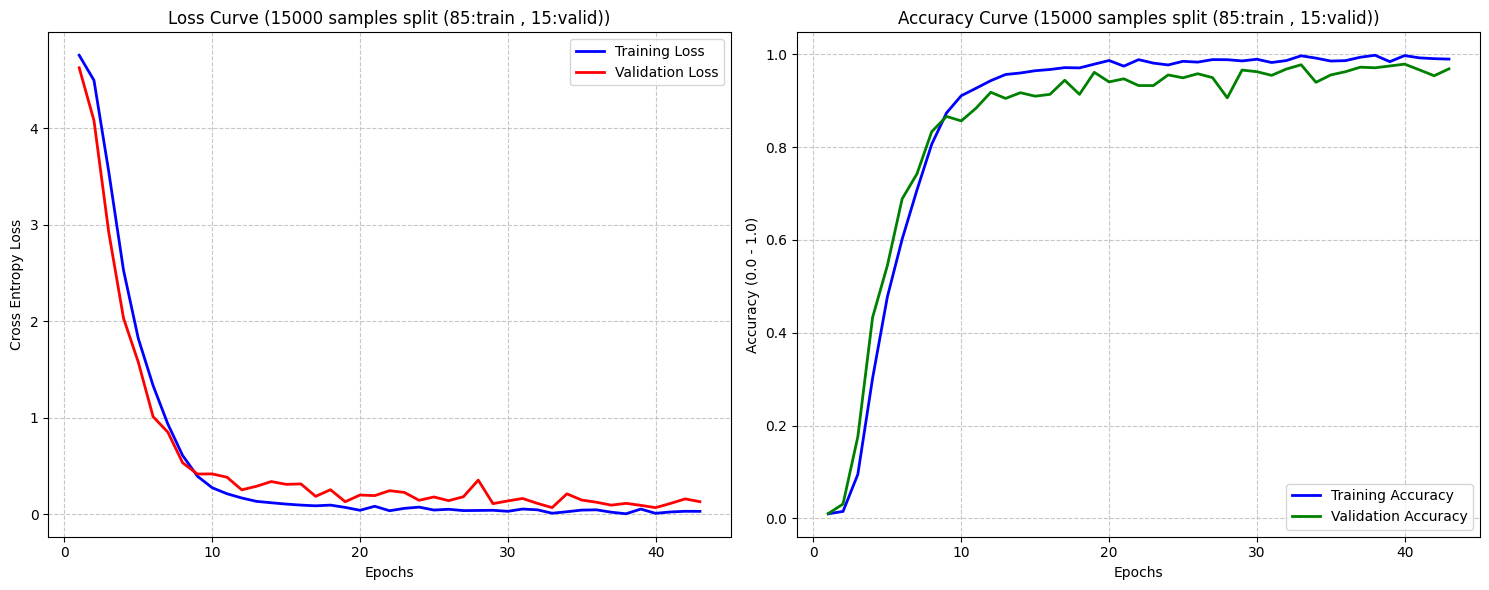

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
PATIENCE = 10
LEARNING_RATE = 0.001
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = WordsOCR(num_classes=100).to(DEVICE)


#loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay to prevent overfitting
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)

# Early Stopping
early_stopper = EarlyStopping(patience=PATIENCE)

# History Storage
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

def calculate_accuracy(preds, targets):

    # Get the index of the max logit (the predicted class)
    predicted_classes = torch.argmax(preds, dim=1)
    correct = (predicted_classes == targets).sum().item()
    return correct / targets.size(0)

print(f"Starting Task 1 Classification Training on {DEVICE}...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

#train
    model.train()
    train_loss_accum = 0
    train_acc_accum = 0
    num_batches = 0

    for batch_idx, data in enumerate(train_loader):
        images = data[0].to(DEVICE)
        targets = data[1].to(DEVICE)

        preds = model(images)

        loss = criterion(preds, targets)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        acc = calculate_accuracy(preds, targets)

        train_loss_accum += loss.item()
        train_acc_accum += acc
        num_batches += 1

    avg_train_loss = train_loss_accum / num_batches
    avg_train_acc = train_acc_accum / num_batches



#validation
    model.eval()
    val_loss_accum = 0
    val_acc_accum = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
            images = data[0].to(DEVICE)
            targets = data[1].to(DEVICE)

            preds = model(images)

            loss = criterion(preds, targets)

            acc = calculate_accuracy(preds, targets)

            val_loss_accum += loss.item()
            val_acc_accum += acc
            num_val_batches += 1

    avg_val_loss = val_loss_accum / num_val_batches
    avg_val_acc = val_acc_accum / num_val_batches

    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc*100:.2f}%")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {avg_val_acc*100:.2f}%")

    # Update History
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_acc'].append(avg_val_acc)

    early_stopper(avg_val_loss, model)

    if early_stopper.early_stop:
        print(f"\n[Stopping] Early stopping triggered. Best Val Loss: {early_stopper.best_loss:.4f}")
        break

print("Training Complete.")


def plot_classification_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 6))

    # PLOT 1: LOSS (Train vs Val)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    plt.title("Loss Curve (15000 samples split (85:train , 15:valid))")
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # PLOT 2: ACCURACY (Train vs Val)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, history['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
    plt.title("Accuracy Curve (15000 samples split (85:train , 15:valid))")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (0.0 - 1.0)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

torch.save(model.cnn.state_dict(),"PretrainedFromClassifier.pth")

# Run the plotter
plot_classification_results(history)